In [35]:
import numpy as np
import pandas as pd


from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, roc_auc_score

from scipy.special import erfinv

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event

import torch
from torch import nn
from torch.utils.data import *
from torch.optim import *
# from fastai.model import *
# from fastai.column_data import *
# from fastai.dataloader import *
from torch.utils.data import DataLoader as torch_dl

from keras.models import Model
from keras.layers import Dense, Input
from keras.datasets import mnist
from keras.regularizers import l1
from keras.optimizers import Adam

from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        cl = DBSCAN(eps=self.eps, min_samples=1, algorithm='kd_tree')
        labels = cl.fit_predict(X)
        
        return labels

In [3]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [2]:
# say we have a straight line function
# y = mx + c
# let m = 5, c = 20, x in {0, 100}
x = torch.FloatTensor(2500).random_(0, 100)

In [3]:
m =5
c = 20

In [4]:
y = m * x + c

In [5]:
import matplotlib.pyplot as plt

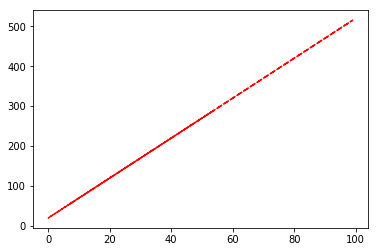

In [102]:
plt.plot(x.cpu().numpy(), y.cpu().numpy(), 'r--')
plt.show()

In [103]:
X = x.cpu().numpy()
Y = y.cpu().numpy()

In [104]:
df = pd.DataFrame(X)
df.columns = ['x']
df['y'] = Y
X_train = df.as_matrix()
# X_train = X_train.reshape(1, -1)

In [105]:
X_train.shape

(2500, 2)

In [129]:
# now add some noise
X_noisy = x.cpu().numpy()
Y_noisy = y.cpu().numpy()

In [130]:
X_noisy = X_noisy + 2*np.random.randn(2500)
Y_noisy = Y_noisy + 2*np.random.randn(2500) 

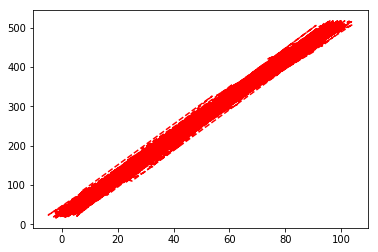

In [131]:
plt.plot(X_noisy, Y_noisy, 'r--')
plt.show()

In [132]:
df_noisy = pd.DataFrame(X_noisy)
df_noisy.columns = ['x']
df_noisy['y'] = Y_noisy
X_noisy_train = df_noisy.as_matrix()
# X_noisy_train = X_noisy_train.reshape(1, -1)

In [133]:
df_noisy.head()

,x,y
0,7.835179,58.871837
1,83.571448,442.617428
2,42.484776,233.200482
3,54.359643,286.356195
4,13.551167,92.034242


In [134]:
df_noisy.shape

(2500, 2)

In [135]:
X_noisy_train.shape

(2500, 2)

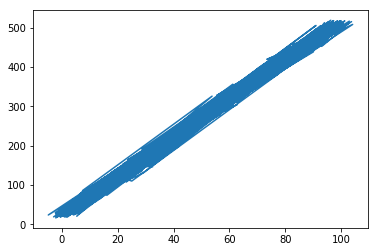

In [136]:
plt.plot(df_noisy.x.values, df_noisy.y.values)
plt.show()

In [142]:
input_size = 2
hidden_size1 = 100
# hidden_size2 = 100
code_size = 2



In [143]:
input_img = Input(shape=(input_size,))
hidden_1 = Dense(hidden_size1, activation='relu')(input_img)
code = Dense(code_size, activation='relu')(hidden_1)
hidden_3 = Dense(hidden_size1, activation='relu')(code)
output_img = Dense(input_size, activation='relu')(hidden_3)


In [144]:
# input_img = Input(shape=(input_size,))
# hidden_1 = Dense(hidden_size1, activation='relu')(input_img)
# hidden_2 = Dense(hidden_size2, activation='relu')(hidden_1)
# code = Dense(code_size, activation='relu')(hidden_2)
# hidden_3 = Dense(hidden_size2, activation='relu')(code)
# hidden_4 = Dense(hidden_size1, activation='relu')(hidden_3)
# output_img = Dense(input_size, activation='sigmoid')(hidden_4)



In [145]:
autoencoder = Model(input_img, output_img)
autoencoder.compile(optimizer='adam', loss='mse')

In [146]:
autoencoder.fit(X_noisy_train, X_train, batch_size=1024, epochs=500)

Epoch 1/500
2500/2500 [==============================] - 0s 164us/step - loss: 47384.3024
Epoch 2/500
2500/2500 [==============================] - 0s 5us/step - loss: 47233.6350
Epoch 3/500
2500/2500 [==============================] - 0s 6us/step - loss: 47050.7785
Epoch 4/500
2500/2500 [==============================] - 0s 5us/step - loss: 46839.8646
Epoch 5/500
2500/2500 [==============================] - 0s 5us/step - loss: 46604.3520
Epoch 6/500
2500/2500 [==============================] - 0s 5us/step - loss: 46369.5193
Epoch 7/500
2500/2500 [==============================] - 0s 5us/step - loss: 46150.7746
Epoch 8/500
2500/2500 [==============================] - 0s 5us/step - loss: 45987.7961
Epoch 9/500
2500/2500 [==============================] - 0s 4us/step - loss: 45905.4202
Epoch 10/500
2500/2500 [==============================] - 0s 4us/step - loss: 45905.2549
Epoch 11/500
2500/2500 [==============================] - 0s 4us/step - loss: 45946.2986
Epoch 12/500
2500/2500 [====

2500/2500 [==============================] - 0s 5us/step - loss: 45893.7487
Epoch 94/500
2500/2500 [==============================] - 0s 4us/step - loss: 45893.7465
Epoch 95/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7376
Epoch 96/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7368
Epoch 97/500
2500/2500 [==============================] - 0s 4us/step - loss: 45893.7270
Epoch 98/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7194
Epoch 99/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7125
Epoch 100/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7071
Epoch 101/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.7035
Epoch 102/500
2500/2500 [==============================] - 0s 5us/step - loss: 45893.6950
Epoch 103/500
2500/2500 [==============================] - 0s 4us/step - loss: 45893.6899
Epoch 104/500
2500/2500 [=====

2500/2500 [==============================] - 0s 5us/step - loss: 173.7861
Epoch 276/500
2500/2500 [==============================] - 0s 4us/step - loss: 72.1070
Epoch 277/500
2500/2500 [==============================] - 0s 5us/step - loss: 9.6050
Epoch 278/500
2500/2500 [==============================] - 0s 5us/step - loss: 14.5690
Epoch 279/500
2500/2500 [==============================] - 0s 4us/step - loss: 38.2696
Epoch 280/500
2500/2500 [==============================] - 0s 5us/step - loss: 39.3306
Epoch 281/500
2500/2500 [==============================] - 0s 4us/step - loss: 20.9491
Epoch 282/500
2500/2500 [==============================] - 0s 4us/step - loss: 5.8829
Epoch 283/500
2500/2500 [==============================] - 0s 4us/step - loss: 4.4845
Epoch 284/500
2500/2500 [==============================] - 0s 4us/step - loss: 9.2776
Epoch 285/500
2500/2500 [==============================] - 0s 5us/step - loss: 10.5809
Epoch 286/500
2500/2500 [==============================] - 0

2500/2500 [==============================] - 0s 4us/step - loss: 3.0087
Epoch 466/500
2500/2500 [==============================] - 0s 5us/step - loss: 3.0075
Epoch 467/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0067
Epoch 468/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0050
Epoch 469/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0035
Epoch 470/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0023
Epoch 471/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0021
Epoch 472/500
2500/2500 [==============================] - 0s 4us/step - loss: 3.0015
Epoch 473/500
2500/2500 [==============================] - 0s 5us/step - loss: 2.9994
Epoch 474/500
2500/2500 [==============================] - 0s 4us/step - loss: 2.9974
Epoch 475/500
2500/2500 [==============================] - 0s 4us/step - loss: 2.9968
Epoch 476/500
2500/2500 [==============================] - 0s 4us/st

In [147]:
reconstructed = autoencoder.predict(X_noisy_train)

In [148]:
reconstructed.shape

(2500, 2)

In [149]:
X1 = reconstructed.reshape(-1)

In [150]:
X1.shape

(5000,)

In [151]:
Z = X1.reshape(2500, 2)

In [152]:
df_z = pd.DataFrame(Z)

In [153]:
df_z.head()

,0,1
0,9.854275,57.932484
1,83.765526,442.565521
2,43.448711,232.757446
3,53.788345,286.564728
4,16.180674,90.854965


In [154]:
df_z.columns = ['x', 'y']

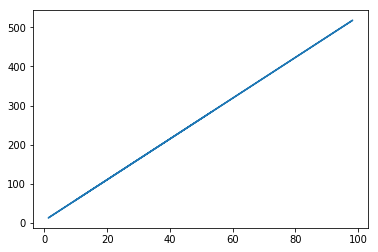

In [155]:
plt.plot(df_z.x.values, df_z.y.values)
plt.show()

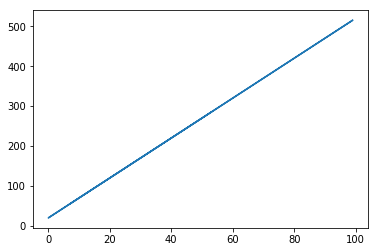

In [156]:
plt.plot(df.x.values, df.y.values)
plt.show()

In [4]:
path_to_train = "../data/train"
event_prefix = "event000001000"

hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))
    

In [5]:
model = Clusterer(eps=0.0075)
labels = model.predict(hits)

In [6]:
submission = create_one_event_submission(0, hits, labels)
score = score_event(truth, submission)

In [7]:
print(score)

0.2035354765752354


In [37]:
truth['x'] = truth['tx'].values
truth['y'] = truth['ty'].values
truth['z'] = truth['tz'].values

In [38]:
model = Clusterer(eps=0.0075)
labels = model.predict(truth)
submission = create_one_event_submission(0, truth, labels)
score = score_event(truth, submission)
print(score)

0.20280350429532562


In [8]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833


In [9]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [10]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


In [11]:
hits1 = pd.merge(hits, truth, how='left', on='hit_id')

In [12]:
hits1.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [13]:
hits1 = hits1.drop(['x2','y2','z2'],axis=1)

In [14]:
hits1.shape

(120939, 15)

In [15]:
hits1.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,-55.336102,0.635342,-1502.5,7,2,1,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,-96.109100,-8.241030,-1502.5,7,2,1,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,-62.673599,-9.371200,-1502.5,7,2,1,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


In [16]:
hits1['vlm_id'] = hits1['volume_id'].astype('str') + '_' + hits1['layer_id'].astype('str') + '_' + hits1['module_id'].astype('str')

In [17]:
hits1.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight,vlm_id
0,1,-64.409897,-7.163700,-1502.5,7,2,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000,7_2_1
1,2,-55.336102,0.635342,-1502.5,7,2,1,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010,7_2_1
2,3,-83.830498,-1.143010,-1502.5,7,2,1,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000,7_2_1
3,4,-96.109100,-8.241030,-1502.5,7,2,1,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008,7_2_1
4,5,-62.673599,-9.371200,-1502.5,7,2,1,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009,7_2_1


In [18]:
hits1.vlm_id.nunique()

17471

In [19]:
vlm_id_list = list(set(hits1.vlm_id.values))

In [20]:
hits.hit_id.nunique()

120939

In [21]:
from tqdm import tqdm

In [22]:
scores = []
for i, vlm_id in tqdm(enumerate(vlm_id_list)):
    if i > 10:
        continue
    df_h = hits1[hits1.vlm_id == vlm_id]
    df_t = truth[truth.hit_id.isin(df_h.hit_id.values)]
    
    model = Clusterer(eps=0.0075)
    labels = model.predict(df_h)
    
    submission = create_one_event_submission(0, df_h, labels)
    score = score_event(df_t, submission)
    scores.append(score)

17471it [00:02, 7430.81it/s]


In [23]:
scores

[0.0,
 1.0000000355930405,
 0.9999999722544163,
 1.0000000181265711,
 0.0,
 1.0,
 0.9999999549747012,
 0.9999999765573251,
 0.0,
 0.0,
 1.0]

In [ ]:
def DAE():
    input_size = 3
    hidden_size1 = 100
    # hidden_size2 = 100
    code_size = 3

    input_img = Input(shape=(input_size,))
    hidden_1 = Dense(hidden_size1, activation='relu')(input_img)
    code = Dense(code_size, activation='relu')(hidden_1)
    hidden_3 = Dense(hidden_size1, activation='relu')(code)
    output_img = Dense(input_size, activation='relu')(hidden_3)

    dae = Model(input_img, output_img)
    dae.compile(optimizer='adam', loss='mse')
    
    return dae

def corrupt_input(X, Y, Z):
    X_noisy = 2*np.random.randn(2500)

In [40]:
# from scipy.spatial.distance import cdist

In [28]:
A = hits1[['tx', 'ty', 'tz']]
B = hits1[['x', 'y', 'z']]


In [29]:
print(A.shape)
print(B.shape)

(120939, 3)
(120939, 3)


In [30]:
A.head()

,tx,ty,tz
0,-64.411598,-7.164120,-1502.5
1,-55.338501,0.630805,-1502.5
2,-83.828003,-1.145580,-1502.5
3,-96.122902,-8.230360,-1502.5
4,-62.659401,-9.375040,-1502.5


In [31]:
eu = []
for index, row in hits1.iterrows():
    tx = row['tx']
    ty = row['ty']
    tz = row['tz']
    
    x = row['x']
    y = row['y']
    z = row['z']
    
    A = np.array([tx, ty, tz])
    B = np.array([x, y, z])
    
    eu.append(np.linalg.norm(A-B))

In [32]:
len(eu)

120939

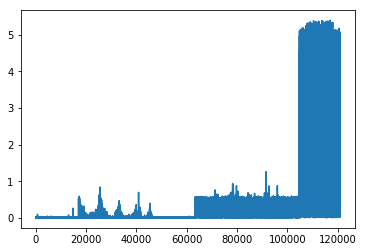

In [36]:
plt.plot(eu)

In [27]:
dist_eu.shape

()

In [ ]:
C = cdist(A, B)

In [ ]:
for i, vlm_id in tqdm(enumerate(vlm_id_list)):
    if i > 10:
        continue
    df_h = hits1[hits1.vlm_id == vlm_id]
    df_t = truth[truth.hit_id.isin(df_h.hit_id.values)]
    
    df_ht = df_h[['tx', 'ty', 'tz']]
    df_hm = df_h[['x', 'y', 'z']]
    
    df
    